In [1]:
### TO BE DELETED
from time import perf_counter
from tqdm import tqdm
WATCHLIST = [2480, 4497, 6329, 726, 4933, 3626, 5359, 5373, 6001]
OPT_LIST = [5084, 6251, 6276, 6289, 5992]
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [2]:
######################### Imports
import pandas as pd
from os import listdir, mkdir
from fnmatch import fnmatch
import numpy as np
from astropy.io import fits
from astropy import wcs
import matplotlib.pyplot as plt
import cv2 as cv
import sys
sys.path.insert(1, 'TPA/pavlidis/build/lib.win-amd64-3.9')
from pavlidis import pavlidis

In [3]:
######################### Function definitions
def insideCoordinate(img, x, y):
    if img[y,x-1] == 255 and img[y,x+1] == 255 and img[y-1,x] == 255 and img[y+1,x] == 255:
        return True
    return False

def getEdgeCoordinates(array_2d, cx, cy):
    min_vert = 71
    min_hor = 10
    align_l = 5
    align_r = 6
    vertical_diff = 0
    y1, x1, y2, x2 = array_2d[:,0].min(), array_2d[:,1].min(), array_2d[:,0].max()+1, array_2d[:,1].max()+1

    if y2 - y1 < min_vert:
        vertical_diff = min_vert - (y2 - y1)
        # print("Top alignment:", )
        y1 = max(0, y2 - min_vert)
    if x2 - x1 < min_hor:
        if cx - x1 < align_l:
            # print("Left alignment:", align_l - (cx - x1))
            x1 = max(0, cx - align_l)
        if x2 - cx < align_r:
            # print("Right alignment:", align_r - (x2 - cx))
            x2 = min(9600, cx + align_r)
    return y1, x1, y2, x2, vertical_diff

def prepareData(path):
    data = pd.read_csv(path)
    data.drop(0, inplace=True)
    data.reset_index(drop=True, inplace=True)

    data["plate"] = np.nan
    data["path"] = np.nan
    data["dx"] = np.zeros(data.shape[0])
    data["dy"] = np.zeros(data.shape[0])
    data[['_RAJ2000', '_DEJ2000']] = data[['_RAJ2000', '_DEJ2000']].astype(float)

    # print(data.head())
    return data

def prepareFits(headers_path, fits_path, headers_pattern, fits_pattern):
    headers_folder = listdir(headers_path)
    fits_folder = listdir(fits_path)

    fits_headers = []
    fits_files = []

    headers_pattern = headers_pattern
    fits_pattern = fits_pattern

    for entry in headers_folder:
        if fnmatch(entry, headers_pattern):
                fits_headers.append('./data/fits_headers/' + entry)

    for entry in fits_folder:
        if fnmatch(entry, fits_pattern):
                fits_files.append('./data/fits_files/' + entry)

    # print(fits_headers[:5])
    # print('Files in headers folder:', len(headers_folder))
    # print('Headers in headers folder:', len(fits_headers))
    # print()
    # print(fits_files[:5])
    # print('Files in fits folder:', len(fits_folder))
    # print('Fits files in fits folder:', len(fits_files))

    fits_headers = np.array(fits_headers)
    fits_files = np.array(fits_files)
    fits_set = set(map(lambda x: x.split('/')[-1].split('.')[0], fits_files))

    return fits_headers, fits_files, fits_set

def getCoordinates(fits_headers, data):
    coordinates = np.ones((len(fits_headers), data.shape[0], 2)) * (-1)

    for i in range(len(fits_headers)):
        hdulist = fits.open(fits_headers[i])
        w = wcs.WCS(hdulist[0].header)

        xy = w.all_world2pix(data[['_RAJ2000', '_DEJ2000']], 1, quiet=True)

        matching_indices = np.where((xy[:,0] >= 0) & (xy[:,0] <= 9601) & (xy[:,1] >= 0) & (xy[:,1] <= 9601))[0]

        coordinates[i][matching_indices] = xy[matching_indices]

    return coordinates

def getPlateCoordinates(xy, mx, my):
    return np.where((xy[:,0] >= 0) & (xy[:,0] < mx) & (xy[:,1] >= 0) & (xy[:,1] < my))[0]

def extractObject(img, dx, dy):
    pass

In [4]:
######################### Process
data = prepareData(
    path='data/DFBS.csv')
data.head()

,_Glon,_Glat,_RAJ2000,_DEJ2000,Cl,Name,Vmag,z,plate,path,dx,dy
0,100.174423,-55.203358,0.048750,5.388056,Sy1,RXS J00001+0523,16.4,0.040,NaN,NaN,0.0,0.0
1,99.844434,-57.30727,0.610000,3.351667,Sy1,MARK 543,14.68,0.026,NaN,NaN,0.0,0.0
2,86.112841,-70.112882,0.883750,-10.744722,Sy1,NGC 7808,15.4,0.029,NaN,NaN,0.0,0.0
3,114.304767,-16.638006,1.039583,45.440278,Sy1,RXS J00041+4526,16.9,0.120,NaN,NaN,0.0,0.0
4,104.972206,-50.897341,1.456250,10.376944,Sy1,RXS J00058+1022,16.7,0.095,NaN,NaN,0.0,0.0


In [12]:
raw_folders = ['images', 'images_2']
classified_folders = ['images_classes', 'images_classes_2']
for folder in raw_folders + classified_folders:
    try:
        mkdir(f'data/' + folder)
    except OSError as error:
        pass

for folder in classified_folders:
    for class_name in np.unique(data['Cl']):
        try:
            mkdir(f'data/{folder}/{class_name}')
        except OSError as error:
            pass

In [6]:
fits_headers, fits_files, fits_set = prepareFits(
    headers_path='data/fits_headers',
    fits_path='data/fits_files',
    headers_pattern="*.hdr",
    fits_pattern="*.fits")

coordinates = getCoordinates(
    fits_headers=fits_headers,
    data=data)
np.save('data/coordinates.csv', coordinates+1)
# coordinates = np.load('data/coordinates.csv.npy') - 1

In [13]:
datapoint_plates = dict({})
all_datapoints = set({})

incorrect_coordinate_count = 0
incorrect_datapoints = dict({})
short_images_extracted_count = 0
short_20_images = set({})
short_30_images = set({})

for i in tqdm(range(len(fits_headers))):
    plate = fits_headers[i].split('/')[-1].split('.')[0]
    if plate in fits_set:
        fbs_plate = fits.open('./data/fits_files/' + plate + '.fits')

        plate_img = fbs_plate[0].data
        shape_y, shape_x = plate_img.shape
        del fbs_plate
        
        scaled_img = ((plate_img/plate_img.max())*255).astype(np.uint8)
        del plate_img

        if np.mean(scaled_img) < 127.5:
            scaled_img = np.invert(scaled_img)

        gblur = cv.GaussianBlur(scaled_img, (3, 3), 2, 2)
        # del scaled_img #########################################################################

        g_th = cv.adaptiveThreshold(gblur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
                    cv.THRESH_BINARY_INV,21,2)
        
        del gblur #########################################################################

        plate_datapoints = getPlateCoordinates(coordinates[i], shape_x, shape_y)
        for pd_i in plate_datapoints:
            if pd_i not in all_datapoints: ###############################################################################
                all_datapoints.add(pd_i)
            if pd_i not in datapoint_plates:
                dx, dy = np.round(coordinates[i, pd_i]).astype(int)
                if g_th[dy,dx] == 255:
                    while (dy < shape_y - 1) and insideCoordinate(g_th, dx, dy):
                        dy += 1

                    try:
                        pavl_res = pavlidis(g_th, dy, dx)
                        y1, x1, y2, x2, vd = getEdgeCoordinates(pavl_res, dx, dy)
                        if y2 - y1 - vd > 20:
                            result = np.invert(scaled_img[y1:y2,x1:x2])
                            result_sized = cv.resize(scaled_img[y1:y2,x1:x2], (20, 140))
                            
                            datapoint_plates[pd_i] = dict({ ##########################
                                'plate': plate,
                                'dx': dx,
                                'dy': dy,
                            })

                            image_path = f'data/{raw_folders[0]}/{pd_i}__{data.loc[pd_i, "Name"]}.png'
                            image_2_path = f'data/{raw_folders[1]}/{pd_i}__{data.loc[pd_i, "Name"]}.png'
                            classes_path = f'data/{classified_folders[0]}/{data.loc[pd_i, "Cl"]}/{pd_i}__{data.loc[pd_i, "Name"]}.png'
                            classes_2_path = f'data/{classified_folders[1]}/{data.loc[pd_i, "Cl"]}/{pd_i}__{data.loc[pd_i, "Name"]}.png'

                            data.loc[pd_i, 'dx'] = dx
                            data.loc[pd_i, 'dy'] = dy
                            data.loc[pd_i, 'plate'] = plate
                            data.loc[pd_i, 'path'] = image_path

                            cv.imwrite(image_path, result)
                            cv.imwrite(image_2_path, result_sized)
                            cv.imwrite(classes_path, result)
                            cv.imwrite(classes_2_path, result_sized)
                            
                            incorrect_datapoints.pop(pd_i, None)
                        else:
                            if pd_i not in short_20_images:
                                short_20_images.add(pd_i)
                    except AssertionError as err:
                        print(err)
                    except Exception as err2:
                        print(err2)
                else:
                    extracted = False
                    for i_x in range(max(0, dx - 2), min(shape_x, dx + 3)):
                        if extracted:
                            break
                        for i_y in range(dy, max(-1, dy - 3), -1):
                            if extracted:
                                break
                            if i_x == dx and i_y == dy: continue
                            dx = i_x; i_y = dy
                            if g_th[dy,dx] == 255:
                                while (dy < shape_y - 1) and insideCoordinate(g_th, dx, dy):
                                    dy += 1
                                try:
                                    pavl_res = pavlidis(g_th, dy, dx)
                                    y1, x1, y2, x2, vd = getEdgeCoordinates(pavl_res, dx, dy)

                                    if y2 - y1 - vd > 20:
                                        result = scaled_img[y1:y2,x1:x2]
                                        result_sized = cv.resize(scaled_img[y1:y2,x1:x2], (20, 140))

                                        datapoint_plates[pd_i] = dict({ ##########################
                                            'plate': plate,
                                            'dx': dx,
                                            'dy': dy,
                                        })

                                        image_path = f'data/{raw_folders[0]}/{pd_i}__{data.loc[pd_i, "Name"]}.png'
                                        image_2_path = f'data/{raw_folders[1]}/{pd_i}__{data.loc[pd_i, "Name"]}.png'
                                        classes_path = f'data/{classified_folders[0]}/{data.loc[pd_i, "Cl"]}/{pd_i}__{data.loc[pd_i, "Name"]}.png'
                                        classes_2_path = f'data/{classified_folders[1]}/{data.loc[pd_i, "Cl"]}/{pd_i}__{data.loc[pd_i, "Name"]}.png'

                                        data.loc[pd_i, 'dx'] = dx
                                        data.loc[pd_i, 'dy'] = dy
                                        data.loc[pd_i, 'plate'] = plate
                                        data.loc[pd_i, 'path'] = image_path

                                        cv.imwrite(image_path, result)
                                        cv.imwrite(image_2_path, result_sized)
                                        cv.imwrite(classes_path, result)
                                        cv.imwrite(classes_2_path, result_sized)

                                        incorrect_datapoints.pop(pd_i, None)

                                        extracted = True
                                        short_images_extracted_count += 1
                                    else:  
                                        if pd_i not in short_30_images:
                                            short_30_images.add(pd_i)
                                except AssertionError as err:
                                    print("Nerqin error", err)
                                except Exception as err2:
                                    print("Nerqin error2", err2)
                    if extracted == False:
                        incorrect_coordinate_count += 1
                        if pd_i not in incorrect_datapoints:
                            incorrect_datapoints[pd_i] = [plate]
                        else:
                            incorrect_datapoints[pd_i].append(plate)
            else:
                continue


data = data[data['plate'].notna()]
data.to_csv('data/DFBS_extracted.csv')


print('all_datapoints:', len(all_datapoints))
# print('incorrect_coordinate_count:', incorrect_coordinate_count)
print('incorrect_datapoints:', len(incorrect_datapoints))
print('short_20_images:', len(short_20_images.difference(incorrect_datapoints, datapoint_plates)))
print('short_30_images:', len(short_30_images.difference(incorrect_datapoints, datapoint_plates)))
print('extracted images count:', len(all_datapoints) - len(short_20_images.difference(incorrect_datapoints, datapoint_plates))\
    - len(short_30_images.difference(incorrect_datapoints, datapoint_plates))\
        - len(incorrect_datapoints))
print('short_images_extracted_count:', short_images_extracted_count)

100%|██████████| 1700/1700 [09:13<00:00,  3.07it/s]


all_datapoints: 1586
incorrect_datapoints: 329
short_20_images: 179
short_30_images: 0
extracted images count: 1078
short_images_extracted_count: 232


In [43]:
((len(all_datapoints) - len(incorrect_datapoints) - len(short_20_images.difference(incorrect_datapoints, datapoint_plates)) \
    - len(short_30_images.difference(incorrect_datapoints, datapoint_plates)))/len(all_datapoints)) * 100

68.41741534208707

In [113]:
# s = 0
# for i in incorrect_datapoints:
#     s += len(incorrect_datapoints[i]) - 1
# s

# len(set(incorrect_datapoints.keys()).union(short_20_images).union(short_30_images).difference(datapoint_plates.keys()))

990

In [103]:
len(short_20_images.difference(incorrect_datapoints.keys(), datapoint_plates.keys())),\
len(short_30_images.difference(incorrect_datapoints.keys(), datapoint_plates.keys()))

(158, 0)

In [44]:
len(all_datapoints), len(incorrect_datapoints)

(1120, 261, 252)

In [50]:
import numpy as np
import pandas as pd
import os
from fnmatch import fnmatch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [51]:
data = pd.read_csv('./data/DFBS_extracted.csv', index_col='Unnamed: 0')
data.head()

,_Glon,_Glat,_RAJ2000,_DEJ2000,Cl,Name,Vmag,z,plate,path,dx,dy
22,120.963506,-22.480532,10.472500,40.354722,Sy1,MARK 957,15.14,0.073,fbs0809_cor,data/images/Sy1/22__MARK 957.tiff,4310.0,7798.0
23,121.040282,-22.511401,10.567083,40.326667,Sy1,IV Zw 29,16.30,0.102,fbs0809_cor,data/images/Sy1/23__IV Zw 29.tiff,4140.0,7738.0
37,129.448039,-49.313722,17.220000,13.337222,Sy1,3C 33.0,15.90,0.060,fbs0089_cor,data/images/Sy1/37__3C 33.0.tiff,2645.0,316.0
38,133.401721,-62.040063,17.747083,0.433611,Sy1,SDSS J01109+0026,15.72,0.019,fbs1175_cor,data/images/Sy1/38__SDSS J01109+0026.tiff,7944.0,7561.0
43,136.759790,-62.174109,19.265000,0.007778,Sy1,2E 0114-0015,16.79,0.046,fbs1175_cor,data/images/Sy1/43__2E 0114-0015.tiff,4394.0,6680.0


In [53]:
all_tiff_files = []
listOfFiles = os.listdir('./data/images_2/')
pattern = "*.tiff"
for entry in listOfFiles:
    if fnmatch(entry, pattern):
        all_tiff_files.append('./data/images_2/'+entry)

all_tiff_files[0], len(all_tiff_files)

('./data/images_2/1036__RXS J00281+3103.tiff', 990)

In [54]:
from time import perf_counter

In [55]:
t1 = perf_counter()
new_index = 0
arr_data = []
t1 = perf_counter()
for index, row in data.iterrows():
    # if index == 0: continue
    glon = row["_Glon"]
    glat = row["_Glat"]
    raj = row["_RAJ2000"]
    dej = row["_DEJ2000"]
    cl = row["Cl"]
    name = row["Name"]
    vmag = row["Vmag"]
    z = row["z"]
    plate = row["plate"]
    dx = row["dx"]
    dy = row["dy"]
    if cl == "C" or cl == "cv": 
        continue
        
    for i in range(len(all_tiff_files)):
        tiff_index, file_name = all_tiff_files[i].split("/")[-1].split(".tiff")[0].split('__');
        if (name == file_name) and (index == int(tiff_index)):
            arr_data.append([name, cl, all_tiff_files[i]])
            break

len(arr_data), perf_counter() - t1

(968, 0.6494662999975844)

In [56]:
cl_data = pd.DataFrame(arr_data)
cl_data.head()

,0,1,2
0,MARK 957,Sy1,./data/images_2/22__MARK 957.tiff
1,IV Zw 29,Sy1,./data/images_2/23__IV Zw 29.tiff
2,3C 33.0,Sy1,./data/images_2/37__3C 33.0.tiff
3,SDSS J01109+0026,Sy1,./data/images_2/38__SDSS J01109+0026.tiff
4,2E 0114-0015,Sy1,./data/images_2/43__2E 0114-0015.tiff


In [57]:
cl_data[1].value_counts()

M      246
sd     195
Mrk    146
PN     133
WD      84
Sy1     83
QSO     81
Name: 1, dtype: int64

In [65]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(cl_data[1])
cl_data[1]=le.transform(cl_data[1])
cl_data.head()

,0,1,2
0,MARK 957,4,./data/images_2/22__MARK 957.tiff
1,IV Zw 29,4,./data/images_2/23__IV Zw 29.tiff
2,3C 33.0,4,./data/images_2/37__3C 33.0.tiff
3,SDSS J01109+0026,4,./data/images_2/38__SDSS J01109+0026.tiff
4,2E 0114-0015,4,./data/images_2/43__2E 0114-0015.tiff


In [66]:
values = cl_data[1].value_counts()
num_classes = len(values)
values

0    246
6    195
1    146
2    133
5     84
4     83
3     81
Name: 1, dtype: int64

In [67]:
X = cl_data.iloc[:, 2]
Y = cl_data.iloc[:, 1]

In [68]:
X = X.values
Y = Y.values

In [69]:
images_list = []
max_width = 0
max_height = 0
ind = 0
for i in range(len(X)):
    im = Image.open(X[i])
    arr = np.array(im)#.flatten()
    
    arr=(arr-arr.min())/(arr.max()-arr.min())
    #arr = arr / 0xffff
    s = arr.shape
    if s[0] > max_height:
        max_height = s[0]
    if s[1] > max_width:
        max_width = s[1]
        ind = i
    images_list.append(arr)

In [70]:
print(max_width, max_height)
max_width, max_height = 20, 140

20 140


In [71]:
for i in range(len(images_list)):
    s = images_list[i].shape
    d_width = (max_width - s[1])
    d_height = (max_height - s[0])
    
    d_top = int(d_height / 2)
    d_bottom = int(d_height - d_top)
    
    d_left = int(d_width / 2)
    d_right = int(d_width - d_left)
    #print(d_top, d_bottom, d_left, d_right)
    
    arr = images_list[i]
    for l in range(d_left):
        arr = np.insert(arr, 0, 0, axis = 1)
    
    for r in range(d_right):
        b = np.zeros((s[0],1))
        arr = np.append(arr, b, axis = 1)
    
    for t in range(d_top):
        arr = np.insert(arr, 0, 0, axis = 0)
    
    for b in range(d_bottom):
        b = np.zeros((1, arr.shape[1],))
        arr = np.append(arr, b, axis = 0)
    
    images_list[i] = arr#.flatten()

20 140


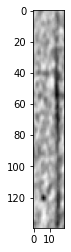

In [72]:
width = max_width
height = max_height
print(width, height)
plt.imshow(images_list[100])
plt.gray()
plt.show()

In [73]:
from tensorflow.python.client import device_lib
import tensorflow as tf
import keras
# print(device_lib.list_local_devices())

In [74]:
images_np = np.array(images_list)
file_names_np = np.array(all_tiff_files)

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(images_np, Y, test_size=0.1, shuffle=True, stratify=Y)
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes)

In [80]:
input_shape = (140, 20, 1)
X_train = X_train.reshape(X_train.shape[0], input_shape[0], input_shape[1], input_shape[2])
X_test = X_test.reshape(X_test.shape[0], input_shape[0], input_shape[1], input_shape[2])

In [81]:
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (871, 140, 20, 1)
871 train samples
97 test samples


In [82]:
datagen = ImageDataGenerator(
    rotation_range=2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest",
    rescale = 1./0xff
)

In [86]:
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation, BatchNormalization, concatenate
from tensorflow.keras import regularizers

In [87]:
reg  = None
reg_l1 = regularizers.l1()
reg_l2 = regularizers.l2()
ks = 16 
drop_size = 0.1
act = "relu"
from keras.callbacks import LearningRateScheduler
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 6:
        lrate = 0.0005
    if epoch > 12:
        lrate = 0.00025
    if epoch > 18:
        lrate = 0.0001
    if epoch > 25:
        lrate = 0.00001
    return lrate

In [85]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape, padding="same"))
model.add(MaxPooling2D(pool_size=(3, 1)))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 1)))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 4)))

model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.5))
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dense(num_classes,activation=tf.nn.softmax))

In [83]:
i = Input(input_shape)

#32----------------------------------------------------------------------------------
t11 = Conv2D(ks,(2,2),kernel_regularizer = reg,padding = "same",activation = act)(i)
t11 = BatchNormalization()(t11)
t1i  = concatenate((i,t11))

t12 = Conv2D(ks*2,(2,2),kernel_regularizer = reg,padding = "same",activation = act)(t1i)
t12 = BatchNormalization()(t12)
t2i = concatenate((i,t11,t12))

t13 = Conv2D(ks*4,(2,2),kernel_regularizer = reg,padding = "same",activation = act)(t2i)
t13 = BatchNormalization()(t13)
t13 = MaxPooling2D(2,2)(t13)
t13 = Dropout(drop_size*2)(t13)
#16----------------------------------------------------------------------------------
t21 = Conv2D(ks*2,(3,3),kernel_regularizer = reg,padding = "same",activation = act)(t13)
t21 = BatchNormalization()(t21)
t2i2  = concatenate((t13,t21))
t22 = Conv2D(ks*4,(3,3),kernel_regularizer = reg,padding = "same",activation = act)(t2i2)
t22 = BatchNormalization()(t22)
t2i3 = concatenate((t13,t21,t22))
t23 = Conv2D(ks*8,(3,3),kernel_regularizer = reg,padding = "same",activation = act)(t2i3)
t23 = BatchNormalization()(t23)
t23 = MaxPooling2D(2,2)(t23)
t23 = Dropout(drop_size*2)(t23)
#8--------------------------------------------------------------------------------------
t31 = Conv2D(ks*2,(3,3),kernel_regularizer = reg,padding = "same",activation = act)(t23)
t31 = BatchNormalization()(t31)
t3i2  = concatenate((t23,t31))
t32 = Conv2D(ks*4,(3,3),kernel_regularizer = reg,padding = "same",activation = act)(t3i2)
t32 = BatchNormalization()(t32)
t3i3 = concatenate((t23,t31,t32))
t33 = Conv2D(ks*8,(3,3),kernel_regularizer = reg,padding = "same",activation = act)(t3i3)
t33 = BatchNormalization()(t33)
t33 = MaxPooling2D(2,2)(t33)
t33 = Dropout(drop_size*2)(t33)
#4------------------------------------------------------------------------------------
# output = concatenate((t12,t))
# output = BatchNormalization()(output)
# output = GlobalAveragePooling2D()(t6)
# output = GlobalMaxPooling2D()(t6)
output = Flatten()(t33)
# output = Dropout(drop_size*4)
output = Dense(16*ks,kernel_regularizer = reg,activation = act)(output)
output = BatchNormalization()(output)
output = Dropout(2*drop_size)(output)
output = Dense(16*ks,kernel_regularizer = reg,activation = act)(output)
output = BatchNormalization()(output)
output = Dropout(2*drop_size)(output)
output = Dense(16*ks,kernel_regularizer = reg,activation = act)(output)
output = BatchNormalization()(output)
output = Dropout(2*drop_size)(output)

output = Dense(num_classes,activation='softmax')(output)
model = Model(i,output)

model.compile(optimizer ="adam",
                     loss = "categorical_crossentropy",
                      metrics = ["accuracy"])

In [84]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 140, 20, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 140, 20, 16)  80          ['input_2[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 140, 20, 16)  64         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [85]:
def encoder_part():
    from keras.regularizers import l2
    from keras.regularizers import l1
    from keras.layers import Dropout, BatchNormalization, Input
    from tensorflow.keras import Model
    inpu_dim = X_train.shape[1]
    h_1 = 2048
    h_2 = 1024
    h_3 = 512
    out_shape = 7

    input_vect = Input(shape = (inpu_dim,))
    x = BatchNormalization()(input_vect)
    x = Dropout(0.5)(x)
    x = Dense(h_1, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(h_2, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(h_3, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    encoded = Dense(out_shape, activation='softmax')(x)

    encoder = Model(input_vect, encoded)

In [82]:
#image data generator keras
cw = {0:1, 1:1, 2:1, 3:1, 4:1, 5:1, 6:1}
adadelta = tf.keras.optimizers.Adadelta(learning_rate=0.1, rho=0.95)
model.compile(optimizer=adadelta , loss='binary_crossentropy', metrics=['accuracy'])

In [86]:
with tf.device('GPU:0'):
    history = model.fit(X_train, Y_train, epochs = 150, batch_size = 64, shuffle=True, validation_data=(X_test, Y_test), class_weight=cw, workers=-1)

Epoch 1/150
10/10 [==============================] - 24s 942ms/step - loss: 2.0046 - accuracy: 0.3783 - val_loss: 1.8854 - val_accuracy: 0.2980
Epoch 2/150
10/10 [==============================] - 4s 443ms/step - loss: 1.5057 - accuracy: 0.5133 - val_loss: 1.8684 - val_accuracy: 0.2980
Epoch 3/150
10/10 [==============================] - 4s 386ms/step - loss: 1.3423 - accuracy: 0.5483 - val_loss: 1.8925 - val_accuracy: 0.2980
Epoch 4/150
10/10 [==============================] - 4s 373ms/step - loss: 1.1614 - accuracy: 0.6167 - val_loss: 1.9190 - val_accuracy: 0.2980
Epoch 5/150
10/10 [==============================] - 3s 351ms/step - loss: 1.0567 - accuracy: 0.6300 - val_loss: 2.2361 - val_accuracy: 0.2980
Epoch 6/150
 7/10 [====================>.........] - ETA: 1s - loss: 0.8724 - accuracy: 0.6853

KeyboardInterrupt: 

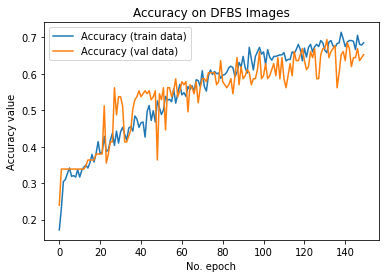

In [102]:
plt.plot(history.history['accuracy'], label='Accuracy (train data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (val data)')
plt.title('Accuracy on DFBS Images')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

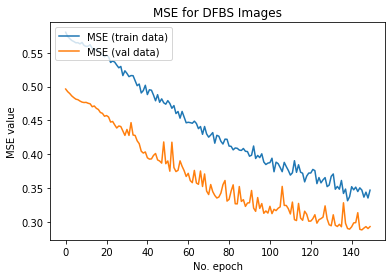

In [103]:
plt.plot(history.history['loss'], label='MSE (train data)')
plt.plot(history.history['val_loss'], label='MSE (val data)')
plt.title('MSE for DFBS Images')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [104]:
from sklearn.metrics import classification_report
import numpy as np

y_test = np.argmax(Y_test, axis=1) # Convert one-hot to index
y_pred = model.predict(X_test)
print(classification_report(Y_test, tf.keras.utils.to_categorical(np.argmax(y_pred, axis=1))))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77        41
           1       0.50      0.60      0.55        20
           2       0.81      0.72      0.76        18
           3       0.23      0.25      0.24        12
           4       0.73      0.63      0.68        30

   micro avg       0.65      0.65      0.65       121
   macro avg       0.61      0.60      0.60       121
weighted avg       0.67      0.65      0.66       121
 samples avg       0.65      0.65      0.65       121



In [105]:
with tf.device('GPU:0'):
    history1 = model.fit(X_train, Y_train, epochs = 150, batch_size = 64, shuffle=True, validation_data=(X_test, Y_test), class_weight=cw, workers=-1)

Epoch 1/150
8/8 [==============================] - 1s 69ms/step - loss: 0.3350 - accuracy: 0.6667 - val_loss: 0.2908 - val_accuracy: 0.6281
Epoch 2/150
8/8 [==============================] - 1s 67ms/step - loss: 0.3301 - accuracy: 0.7060 - val_loss: 0.2920 - val_accuracy: 0.6198
Epoch 3/150
8/8 [==============================] - 0s 60ms/step - loss: 0.3358 - accuracy: 0.7039 - val_loss: 0.2840 - val_accuracy: 0.6612
Epoch 4/150
8/8 [==============================] - 1s 65ms/step - loss: 0.3338 - accuracy: 0.6957 - val_loss: 0.2920 - val_accuracy: 0.6694
Epoch 5/150
8/8 [==============================] - 1s 76ms/step - loss: 0.3353 - accuracy: 0.6915 - val_loss: 0.2986 - val_accuracy: 0.6033
Epoch 6/150
8/8 [==============================] - 1s 67ms/step - loss: 0.3256 - accuracy: 0.6977 - val_loss: 0.3024 - val_accuracy: 0.6694
Epoch 7/150
8/8 [==============================] - 1s 65ms/step - loss: 0.3270 - accuracy: 0.7226 - val_loss: 0.3034 - val_accuracy: 0.6364
Epoch 8/150
8/8 [===

KeyboardInterrupt: 

In [ ]:
accuracy = np.concatenate([history.history['accuracy'], history1.history['accuracy']])
val_accuracy = np.concatenate([history.history['val_accuracy'], history1.history['val_accuracy']])
loss = np.concatenate([history.history['loss'], history1.history['loss']])
val_loss = np.concatenate([history.history['val_loss'], history1.history['val_loss']])

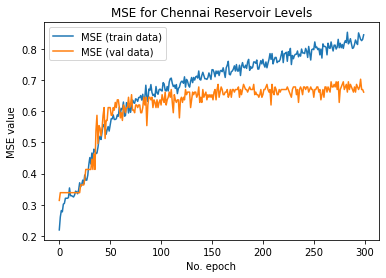

In [ ]:
plt.plot(accuracy, label='MSE (train data)')
plt.plot(val_accuracy, label='MSE (val data)')
plt.title('MSE for Chennai Reservoir Levels')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

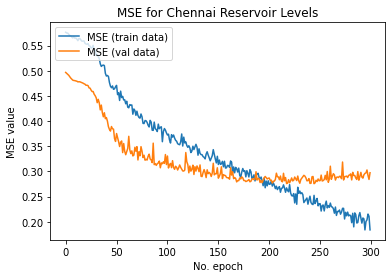

In [ ]:
plt.plot(loss, label='MSE (train data)')
plt.plot(val_loss, label='MSE (val data)')
plt.title('MSE for Chennai Reservoir Levels')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_test = np.argmax(Y_test, axis=1) # Convert one-hot to index
y_pred = model.predict(X_test)
print(classification_report(Y_test, tf.keras.utils.to_categorical(np.argmax(y_pred, axis=1))))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76        41
           1       0.43      0.50      0.47        20
           2       0.89      0.89      0.89        18
           3       0.08      0.08      0.08        12
           4       0.77      0.77      0.77        30

   micro avg       0.66      0.66      0.66       121
   macro avg       0.59      0.59      0.59       121
weighted avg       0.67      0.66      0.66       121
 samples avg       0.66      0.66      0.66       121



In [78]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [79]:
X_train_c = X_train.reshape(-1, 140*20*1)
Y_train_c = Y_train.argmax(axis=1)
X_test_c, Y_test_c = X_test.reshape(-1, 140*20*1), Y_test.argmax(axis=1)

In [80]:
cw = {0:1, 1:2, 2:1, 3:2}

cls = SVC(decision_function_shape='ovo', class_weight=cw)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=10,
    max_leaf_nodes=15,
    # class_weight=class_weight,
    n_jobs=-1)

clf_ada_rf = AdaBoostClassifier(base_estimator=rf, n_estimators=5)

cls.fit(X_train_c, Y_train_c)
print("SVM Accuracy:", cls.score(X_train_c, Y_train_c), cls.score(X_test_c, Y_test_c))

clf_ada_rf.fit(X_train_c, Y_train_c)
print("Ada-RF Accuracy:", clf_ada_rf.score(X_train_c, Y_train_c), clf_ada_rf.score(X_test_c, Y_test_c))

SVM Accuracy: 0.9047619047619048 0.6859504132231405
Ada-RF Accuracy: 0.989648033126294 0.7355371900826446


In [81]:
y_pred_c = cls.predict(X_test_c)
print(classification_report(Y_test, tf.keras.utils.to_categorical(y_pred_c, num_classes=num_classes)))

              precision    recall  f1-score   support

           0       0.68      0.88      0.77        41
           1       0.60      0.60      0.60        20
           2       1.00      0.67      0.80        18
           3       0.17      0.08      0.11        12
           4       0.73      0.73      0.73        30

   micro avg       0.69      0.69      0.69       121
   macro avg       0.64      0.59      0.60       121
weighted avg       0.68      0.69      0.67       121
 samples avg       0.69      0.69      0.69       121



In [82]:
cl_data[1].value_counts()

0    202
4    148
1    101
2     91
3     62
Name: 1, dtype: int64

### ResNet 50

In [83]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Input

In [84]:
X_train_1 = np.repeat(X_train, 3, -1)
X_test_1 = np.repeat(X_test, 3, -1)

In [85]:
input_shape_1 = X_train_1.shape[-3:]

In [86]:
image_input=Input(shape=input_shape_1)
res_model = ResNet50(input_tensor=image_input,weights='imagenet',include_top=False)
res_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 140, 20, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 146, 26, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 70, 10, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 70, 10, 64)   256         ['conv1_conv[0][0]']      

In [87]:
for i, layer in enumerate(res_model.layers[:170]):
    if i < 10: continue
    layer.trainable = False


In [88]:
res_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 140, 20, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 146, 26, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 70, 10, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 70, 10, 64)   256         ['conv1_conv[0][0]']      

In [89]:
model_1 = tf.keras.models.Sequential()
model_1.add(res_model)
model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [95]:
#image data generator keras
cw = {0:1, 1:1, 2:1, 3:1, 4:1}
adam = tf.keras.optimizers.Adam(learning_rate=0.00001)
# adadelta = tf.keras.optimizers.Adadelta(learning_rate=0.1, rho=0.95)
model_1.compile(optimizer=adam , loss='binary_crossentropy', metrics=['accuracy'])

In [96]:
with tf.device('GPU:0'):
    history_resnet = model_1.fit(X_train_1, Y_train, epochs = 15, batch_size = 64, shuffle=True, validation_data=(X_test_1, Y_test), class_weight=cw)

Epoch 1/15
8/8 [==============================] - 9s 627ms/step - loss: 0.8152 - accuracy: 0.2629 - val_loss: 0.8090 - val_accuracy: 0.2479
Epoch 2/15
8/8 [==============================] - 4s 455ms/step - loss: 0.6766 - accuracy: 0.3333 - val_loss: 0.7945 - val_accuracy: 0.2479
Epoch 3/15
8/8 [==============================] - 4s 461ms/step - loss: 0.5832 - accuracy: 0.3727 - val_loss: 0.7796 - val_accuracy: 0.2479
Epoch 4/15
8/8 [==============================] - 4s 481ms/step - loss: 0.5198 - accuracy: 0.4286 - val_loss: 0.7652 - val_accuracy: 0.2479
Epoch 5/15
8/8 [==============================] - 4s 535ms/step - loss: 0.4723 - accuracy: 0.4720 - val_loss: 0.7507 - val_accuracy: 0.2479
Epoch 6/15
8/8 [==============================] - 4s 481ms/step - loss: 0.4445 - accuracy: 0.5010 - val_loss: 0.7374 - val_accuracy: 0.2479
Epoch 7/15
8/8 [==============================] - 4s 483ms/step - loss: 0.4230 - accuracy: 0.5300 - val_loss: 0.7256 - val_accuracy: 0.2479
Epoch 8/15
8/8 [====

In [94]:
from sklearn.metrics import classification_report
import numpy as np

y_test = np.argmax(Y_test, axis=1) # Convert one-hot to index
y_pred_1 = model_1.predict(X_test_1)
print(classification_report(Y_test, tf.keras.utils.to_categorical(np.argmax(y_pred_1, axis=1), num_classes=5)))

y_train = np.argmax(Y_train, axis=1) # Convert one-hot to index
y_pred_train_1 = model_1.predict(X_train_1)
print(classification_report(Y_train, tf.keras.utils.to_categorical(np.argmax(y_pred_train_1, axis=1), num_classes=5)))

e:\Program Files\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        12
           4       0.25      1.00      0.40        30

   micro avg       0.25      0.25      0.25       121
   macro avg       0.05      0.20      0.08       121
weighted avg       0.06      0.25      0.10       121
 samples avg       0.25      0.25      0.25       121

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       161
           1       0.00      0.00      0.00        81
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        50
           4       0.24      1.00      0.39       118

   micro avg       0.24      0.24      0.24       483
   macro avg       0.05      0.20      0.08       483
weighted avg       0.06

e:\Program Files\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred_train_1

array([[0.14071307, 0.10050938, 0.12519541, ..., 0.08803439, 0.11801537,
        0.08247155],
       [0.12660298, 0.09363814, 0.12904377, ..., 0.08132344, 0.11283632,
        0.09330243],
       [0.11055232, 0.08661977, 0.11969834, ..., 0.06121603, 0.12689072,
        0.12831129],
       ...,
       [0.12665989, 0.09283087, 0.11872434, ..., 0.0752013 , 0.12008595,
        0.09431286],
       [0.10335355, 0.0784725 , 0.12054633, ..., 0.06732033, 0.12464813,
        0.12749024],
       [0.11648948, 0.09439416, 0.11837909, ..., 0.07064611, 0.13191739,
        0.09264676]], dtype=float32)